<a href="https://colab.research.google.com/github/ebsenthil/KD-IND-HACK/blob/main/retail-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# XGBoost Inventory Forecasting Model
# This notebook develops a retail inventory prediction model using XGBoost

# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# XGBoost and ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
# Mount Google Drive and load the synthetic data
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to your file location
# Update the path based on where you stored the file in your Google Drive
file_path = '/content/drive/My Drive/synthetic_retail_sales_data.csv'


Mounted at /content/drive


In [ ]:
try:
    df = pd.read_csv(file_path)
    print(f"Data loaded successfully from Google Drive!")
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique products: {df['product_id'].nunique()}")
    print(f"Unique categories: {df['product_category'].nunique()}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please check the file path. Common locations:")
    print("- /content/drive/My Drive/synthetic_retail_sales_data.csv")
    print("- /content/drive/MyDrive/synthetic_retail_sales_data.csv")
    print("- /content/drive/My Drive/Colab Notebooks/synthetic_retail_sales_data.csv")

    # List files in drive to help find the correct path
    print("\nFiles in your Google Drive root:")
    try:
        drive_files = os.listdir('/content/drive/My Drive/')
        for file in drive_files[:10]:  # Show first 10 files
            print(f"  {file}")
    except:
        drive_files = os.listdir('/content/drive/MyDrive/')
        for file in drive_files[:10]:  # Show first 10 files
            print(f"  {file}")

Data loaded successfully from Google Drive!
Dataset shape: (18250, 28)
Date range: 2024-01-01 to 2024-12-30
Unique products: 50
Unique categories: 10


In [ ]:
# Data Exploration and Visualization
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18250 entries, 0 to 18249
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   18250 non-null  object 
 1   product_id             18250 non-null  object 
 2   product_category       18250 non-null  object 
 3   sales_qty              18250 non-null  int64  
 4   price                  18250 non-null  float64
 5   store_id               18250 non-null  object 
 6   day_of_week            18250 non-null  int64  
 7   month                  18250 non-null  int64  
 8   quarter                18250 non-null  int64  
 9   is_weekend             18250 non-null  int64  
 10  is_holiday             18250 non-null  int64  
 11  base_demand            18250 non-null  int64  
 12  price_change_pct       18250 non-null  float64
 13  weather_event          250 non-null    object 
 14  weather_intensity      250 non-null    o

In [ ]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
date                         0
product_id                   0
product_category             0
sales_qty                    0
price                        0
store_id                     0
day_of_week                  0
month                        0
quarter                      0
is_weekend                   0
is_holiday                   0
base_demand                  0
price_change_pct             0
weather_event            18000
weather_intensity        18000
natural_disaster         18150
disaster_severity            0
festival_event           17950
festival_impact_level    17950
economic_event           18050
economic_impact_score        0
combined_event_count         0
is_pre_event                 0
is_post_event                0
sales_lag_7d                 0
sales_lag_30d                0
rolling_avg_7d               0
rolling_avg_30d              0
dtype: int64


In [ ]:
# Visualize sales distribution
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0, 0.5, 'Frequency')

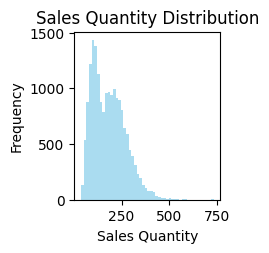

In [ ]:
# Sales quantity distribution
plt.subplot(2, 3, 1)
plt.hist(df['sales_qty'], bins=50, alpha=0.7, color='skyblue')
plt.title('Sales Quantity Distribution')
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Beauty'),
  Text(1, 0, 'Stationery'),
  Text(2, 0, 'Home'),
  Text(3, 0, 'Food'),
  Text(4, 0, 'Books'),
  Text(5, 0, 'Electronics'),
  Text(6, 0, 'Toys'),
  Text(7, 0, 'Sports'),
  Text(8, 0, 'Medicine'),
  Text(9, 0, 'Clothing')])

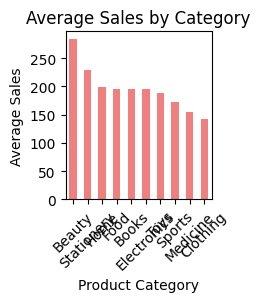

In [ ]:
# Sales by category
plt.subplot(2, 3, 2)
category_sales = df.groupby('product_category')['sales_qty'].mean().sort_values(ascending=False)
category_sales.plot(kind='bar', color='lightcoral')
plt.title('Average Sales by Category')
plt.xlabel('Product Category')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'April'),
  Text(1, 0, 'August'),
  Text(2, 0, 'December'),
  Text(3, 0, 'February'),
  Text(4, 0, 'January'),
  Text(5, 0, 'July'),
  Text(6, 0, 'June'),
  Text(7, 0, 'March'),
  Text(8, 0, 'May'),
  Text(9, 0, 'November'),
  Text(10, 0, 'October'),
  Text(11, 0, 'September')])

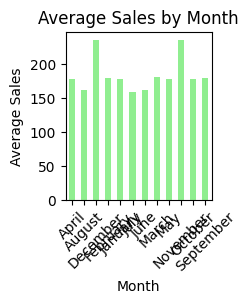

In [ ]:
# Sales by month
plt.subplot(2, 3, 3)
df['month_name'] = pd.to_datetime(df['date']).dt.month_name()
monthly_sales = df.groupby('month_name')['sales_qty'].mean()
monthly_sales.plot(kind='bar', color='lightgreen')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)

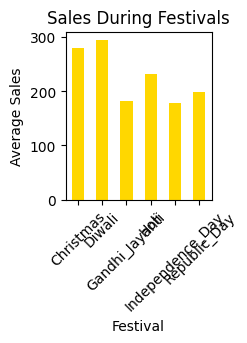

In [ ]:
# External events impact
plt.subplot(2, 3, 4)
festival_impact = df[df['festival_event'] != 'None'].groupby('festival_event')['sales_qty'].mean()
if len(festival_impact) > 0:
    festival_impact.plot(kind='bar', color='gold')
    plt.title('Sales During Festivals')
    plt.xlabel('Festival')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)

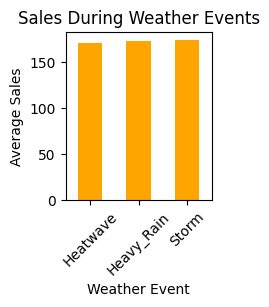

In [ ]:
# Weather events impact
plt.subplot(2, 3, 5)
weather_impact = df[df['weather_event'] != 'None'].groupby('weather_event')['sales_qty'].mean()
if len(weather_impact) > 0:
    weather_impact.plot(kind='bar', color='orange')
    plt.title('Sales During Weather Events')
    plt.xlabel('Weather Event')
    plt.ylabel('Average Sales')
    plt.xticks(rotation=45)

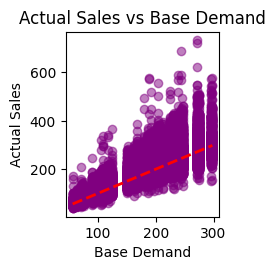

In [ ]:
# Sales vs Base Demand
plt.subplot(2, 3, 6)
plt.scatter(df['base_demand'], df['sales_qty'], alpha=0.5, color='purple')
plt.plot([df['base_demand'].min(), df['base_demand'].max()],
         [df['base_demand'].min(), df['base_demand'].max()], 'r--', lw=2)
plt.title('Actual Sales vs Base Demand')
plt.xlabel('Base Demand')
plt.ylabel('Actual Sales')

plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering and Preprocessing
print("Starting Feature Engineering...")

# Create a copy for preprocessing
df_model = df.copy()

# Convert date to datetime
df_model['date'] = pd.to_datetime(df_model['date'])

# Create additional date features
df_model['year'] = df_model['date'].dt.year
df_model['day_of_month'] = df_model['date'].dt.day
df_model['week_of_year'] = df_model['date'].dt.isocalendar().week

# Create demand ratio (target engineering)
df_model['demand_ratio'] = df_model['sales_qty'] / df_model['base_demand']

# Create external event intensity score
def calculate_external_intensity(row):
    score = 0
    if row['festival_event'] != 'None':
        score += {'Low': 3, 'Medium': 5, 'High': 8}.get(row['festival_impact_level'], 0)
    if row['weather_event'] != 'None':
        score += {'Low': 2, 'Medium': 4, 'High': 6}.get(row['weather_intensity'], 0)
    if row['natural_disaster'] != 'None':
        score += row['disaster_severity']
    if row['economic_event'] != 'None':
        score += row['economic_impact_score']
    return score
df_model['external_intensity'] = df_model.apply(calculate_external_intensity, axis=1)

print("Feature engineering completed!")

Starting Feature Engineering...
Feature engineering completed!


In [ ]:
# Encode categorical variables
categorical_columns = ['product_id', 'product_category', 'weather_event', 'natural_disaster',
                      'festival_event', 'economic_event', 'weather_intensity', 'festival_impact_level']

label_encoders = {}
for col in categorical_columns:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

print("Categorical encoding completed!")

Categorical encoding completed!


In [ ]:
# Prepare features for modeling
feature_columns = [
    # Basic features
    'product_id_encoded', 'product_category_encoded', 'price', 'base_demand',

    # Date features
    'day_of_week', 'month', 'quarter', 'is_weekend', 'is_holiday',
    'day_of_month', 'week_of_year',

    # Lag features
    'sales_lag_7d', 'sales_lag_30d', 'rolling_avg_7d', 'rolling_avg_30d',

    # External events
    'weather_event_encoded', 'natural_disaster_encoded', 'festival_event_encoded',
    'economic_event_encoded', 'disaster_severity', 'economic_impact_score',
    'combined_event_count', 'is_pre_event', 'is_post_event',
    'external_intensity',

    # Price features
    'price_change_pct'
]


In [ ]:
# Remove any columns that don't exist
feature_columns = [col for col in feature_columns if col in df_model.columns]

X = df_model[feature_columns]
y = df_model['sales_qty']

print(f"Features selected: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")

# %%
# Handle missing values
X = X.fillna(X.mean())
print("Missing values handled!")

Features selected: 26
Feature columns: ['product_id_encoded', 'product_category_encoded', 'price', 'base_demand', 'day_of_week', 'month', 'quarter', 'is_weekend', 'is_holiday', 'day_of_month', 'week_of_year', 'sales_lag_7d', 'sales_lag_30d', 'rolling_avg_7d', 'rolling_avg_30d', 'weather_event_encoded', 'natural_disaster_encoded', 'festival_event_encoded', 'economic_event_encoded', 'disaster_severity', 'economic_impact_score', 'combined_event_count', 'is_pre_event', 'is_post_event', 'external_intensity', 'price_change_pct']
Missing values handled!


In [ ]:
# Split data into train and test sets
# Use time-based split (last 2 months for testing)
df_model = df_model.sort_values('date')
split_date = df_model['date'].max() - timedelta(days=60)

train_mask = df_model['date'] <= split_date
test_mask = df_model['date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training period: {df_model[train_mask]['date'].min()} to {df_model[train_mask]['date'].max()}")
print(f"Test period: {df_model[test_mask]['date'].min()} to {df_model[test_mask]['date'].max()}")

Training set size: (15250, 26)
Test set size: (3000, 26)
Training period: 2024-01-01 00:00:00 to 2024-10-31 00:00:00
Test period: 2024-11-01 00:00:00 to 2024-12-30 00:00:00


In [ ]:
# Train XGBoost Model
print("Training XGBoost model...")

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

Training XGBoost model...


In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

print("Model training completed!")

Model training completed!


In [ ]:
# Evaluate Model Performance
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

train_metrics = evaluate_model(y_train, y_pred_train, "Training Set")
test_metrics = evaluate_model(y_test, y_pred_test, "Test Set")



Training Set Performance:
MAE: 14.22
MSE: 324.66
RMSE: 18.02
R²: 0.9454

Test Set Performance:
MAE: 27.72
MSE: 1613.04
RMSE: 40.16
R²: 0.8571


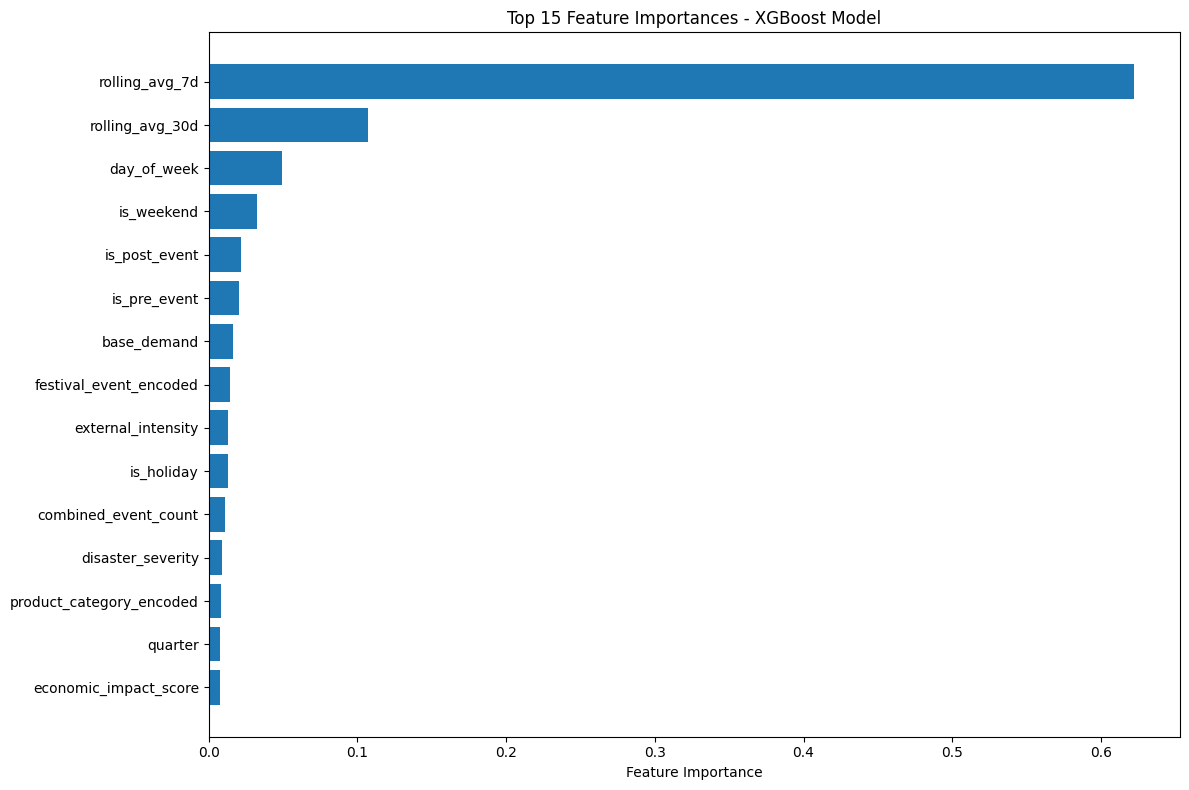


Top 10 Most Important Features:
                   feature  importance
13          rolling_avg_7d    0.622023
14         rolling_avg_30d    0.107360
4              day_of_week    0.049332
7               is_weekend    0.032699
23           is_post_event    0.021719
22            is_pre_event    0.020107
3              base_demand    0.016736
17  festival_event_encoded    0.014225
24      external_intensity    0.012866
8               is_holiday    0.012863


In [ ]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


In [ ]:
# Visualize Predictions vs Actual
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 1.0, 'Training Set: Actual vs Predicted (R² = 0.945)')

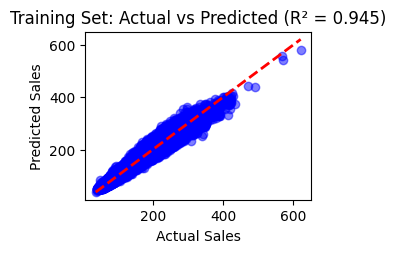

In [ ]:
# Training set predictions
plt.subplot(2, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Training Set: Actual vs Predicted (R² = {train_metrics["R2"]:.3f})')

Text(0.5, 1.0, 'Test Set: Actual vs Predicted (R² = 0.857)')

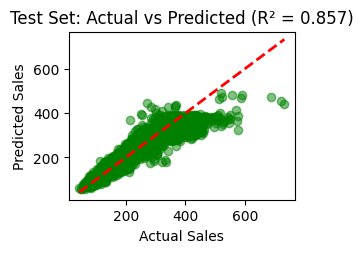

In [ ]:
# Test set predictions
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Test Set: Actual vs Predicted (R² = {test_metrics["R2"]:.3f})')

Text(0.5, 1.0, 'Residuals Plot')

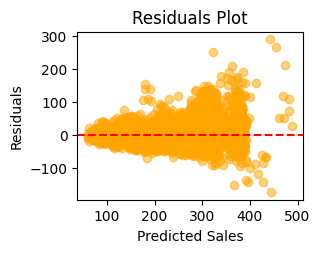

In [ ]:
# Residuals plot
plt.subplot(2, 2, 3)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.5, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

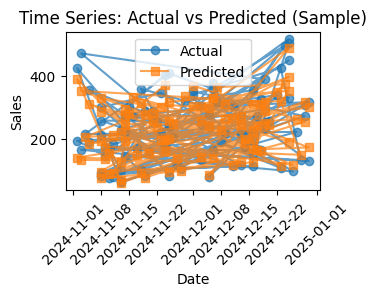

In [ ]:
# Time series prediction
plt.subplot(2, 2, 4)
test_dates = df_model[test_mask]['date'].values
sample_indices = np.random.choice(len(y_test), size=min(100, len(y_test)), replace=False)
plt.plot(test_dates[sample_indices], y_test.iloc[sample_indices], 'o-', label='Actual', alpha=0.7)
plt.plot(test_dates[sample_indices], y_pred_test[sample_indices], 's-', label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Time Series: Actual vs Predicted (Sample)')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter Tuning (Optional - takes time)
print("Starting hyperparameter tuning...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9]
}

# Use a smaller subset for faster tuning
sample_size = min(5000, len(X_train))
sample_indices = np.random.choice(len(X_train), size=sample_size, replace=False)
X_train_sample = X_train.iloc[sample_indices]
y_train_sample = y_train.iloc[sample_indices]

grid_search = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sample, y_train_sample)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.2f}")

# %%
# Train final model with best parameters
print("Training final model with best parameters...")

final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

Starting hyperparameter tuning...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best score: 16.46
Training final model with best parameters...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Final predictions
y_pred_final = final_model.predict(X_test)
final_metrics = evaluate_model(y_test, y_pred_final, "Final Model")



Final Model Performance:
MAE: 27.28
MSE: 1547.61
RMSE: 39.34
R²: 0.8629


In [ ]:
# Save the trained model and preprocessors
print("Saving model and preprocessors...")

# Save the model
joblib.dump(final_model, 'xgboost_inventory_model.pkl')

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

# Save feature columns
joblib.dump(feature_columns, 'feature_columns.pkl')

print("Model and preprocessors saved successfully!")


Saving model and preprocessors...
Model and preprocessors saved successfully!


In [ ]:
# Create prediction function
def predict_inventory(model, encoders, features, input_data):
    """
    Function to predict inventory for new data

    Parameters:
    - model: trained XGBoost model
    - encoders: dictionary of label encoders
    - features: list of feature column names
    - input_data: dictionary with input values

    Returns:
    - predicted_sales: predicted sales quantity
    """

    # Create a dataframe from input
    df_input = pd.DataFrame([input_data])

    # Apply label encoding
    for col, encoder in encoders.items():
        if col in df_input.columns:
            try:
                df_input[col + '_encoded'] = encoder.transform(df_input[col].astype(str))
            except:
                # Handle unseen categories
                df_input[col + '_encoded'] = 0

    # Select only the required features
    X_input = df_input[features].fillna(0)

    # Make prediction
    prediction = model.predict(X_input)[0]

    return max(0, int(prediction))

In [ ]:
# Example prediction
print("Example Prediction:")

sample_input = {
    'product_id': 'SKU001',
    'product_category': 'Food',
    'price': 25.50,
    'base_demand': 150,
    'day_of_week': 5,  # Saturday
    'month': 11,  # November
    'quarter': 4,
    'is_weekend': 1,
    'is_holiday': 0,
    'day_of_month': 15,
    'week_of_year': 46,
    'sales_lag_7d': 160,
    'sales_lag_30d': 145,
    'rolling_avg_7d': 155,
    'rolling_avg_30d': 150,
    'weather_event': 'Heavy_Rain',
    'natural_disaster': 'None',
    'festival_event': 'Diwali',
    'economic_event': 'None',
    'disaster_severity': 0,
    'economic_impact_score': 0,
    'combined_event_count': 2,
    'is_pre_event': 0,
    'is_post_event': 0,
    'external_intensity': 8,
    'price_change_pct': 0
}

predicted_sales = predict_inventory(final_model, label_encoders, feature_columns, sample_input)
print(f"Predicted Sales: {predicted_sales} units")
print(f"Base Demand: {sample_input['base_demand']} units")
print(f"Uplift: {((predicted_sales - sample_input['base_demand']) / sample_input['base_demand'] * 100):.1f}%")

# %%
# Model Summary
print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"Algorithm: XGBoost Regressor")
print(f"Training Samples: {len(X_train):,}")
print(f"Test Samples: {len(X_test):,}")
print(f"Features: {len(feature_columns)}")
print(f"\nTest Set Performance:")
print(f"  MAE: {final_metrics['MAE']:.2f}")
print(f"  RMSE: {final_metrics['RMSE']:.2f}")
print(f"  R²: {final_metrics['R2']:.4f}")
print(f"\nModel saved as: 'xgboost_inventory_model.pkl'")
print(f"Label encoders saved as: 'label_encoders.pkl'")
print(f"Feature columns saved as: 'feature_columns.pkl'")
print("\nModel is ready for inventory predictions!")

Example Prediction:
Predicted Sales: 237 units
Base Demand: 150 units
Uplift: 58.0%

MODEL SUMMARY
Algorithm: XGBoost Regressor
Training Samples: 15,250
Test Samples: 3,000
Features: 26

Test Set Performance:
  MAE: 27.28
  RMSE: 39.34
  R²: 0.8629

Model saved as: 'xgboost_inventory_model.pkl'
Label encoders saved as: 'label_encoders.pkl'
Feature columns saved as: 'feature_columns.pkl'

Model is ready for inventory predictions!


In [ ]:
# Example prediction
print("Example Prediction:")

sample_input = {
    'product_id': 'SKU002',
    'product_category': '',
    'price': 0,
    'base_demand': 150,
    'day_of_week': 5,  # Saturday
    'month': 11,  # November
    'quarter': 4,
    'is_weekend': 1,
    'is_holiday': 0,
    'day_of_month': 15,
    'week_of_year': 46,
    'sales_lag_7d': 160,
    'sales_lag_30d': 145,
    'rolling_avg_7d': 155,
    'rolling_avg_30d': 150,
    'weather_event': 'Heavy_Rain',
    'natural_disaster': 'None',
    'festival_event': 'Diwali',
    'economic_event': 'None',
    'disaster_severity': 0,
    'economic_impact_score': 0,
    'combined_event_count': 2,
    'is_pre_event': 0,
    'is_post_event': 0,
    'external_intensity': 8,
    'price_change_pct': 0
}

predicted_sales = predict_inventory(final_model, label_encoders, feature_columns, sample_input)
print(f"Predicted Sales: {predicted_sales} units")
print(f"Base Demand: {sample_input['base_demand']} units")
print(f"Uplift: {((predicted_sales - sample_input['base_demand']) / sample_input['base_demand'] * 100):.1f}%")

# %%
# Model Summary
print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"Algorithm: XGBoost Regressor")
print(f"Training Samples: {len(X_train):,}")
print(f"Test Samples: {len(X_test):,}")
print(f"Features: {len(feature_columns)}")
print(f"\nTest Set Performance:")
print(f"  MAE: {final_metrics['MAE']:.2f}")
print(f"  RMSE: {final_metrics['RMSE']:.2f}")
print(f"  R²: {final_metrics['R2']:.4f}")
print(f"\nModel saved as: 'xgboost_inventory_model.pkl'")
print(f"Label encoders saved as: 'label_encoders.pkl'")
print(f"Feature columns saved as: 'feature_columns.pkl'")
print("\nModel is ready for inventory predictions!")

Example Prediction:
Predicted Sales: 213 units
Base Demand: 150 units
Uplift: 42.0%

MODEL SUMMARY
Algorithm: XGBoost Regressor
Training Samples: 15,250
Test Samples: 3,000
Features: 26

Test Set Performance:
  MAE: 27.28
  RMSE: 39.34
  R²: 0.8629

Model saved as: 'xgboost_inventory_model.pkl'
Label encoders saved as: 'label_encoders.pkl'
Feature columns saved as: 'feature_columns.pkl'

Model is ready for inventory predictions!
